In [29]:
import numpy as np
import awkward as ak
import uproot
import vector
import mplhep as hep
import matplotlib.pyplot as plt
import os
from optparse import OptionParser
parser = OptionParser(usage="%prog [options]")
from scipy.stats import beta

In [30]:
### FUNCTION DEFINITION ###
def GetMaxMjj(Jets):
    JetCombo = ak.combinations(Jets,2, fields=["jet1","jet2"])
    jjCombo  = JetCombo.jet1 + JetCombo.jet2
    mjjCombo = np.sqrt(np.abs((jjCombo.E)**2 - (jjCombo.px**2 + jjCombo.py**2 + jjCombo.pz**2)))
    maxmjj   = ak.max(mjjCombo,axis=1)
    return maxmjj

def GetMaxEta(Jets):
    JetCombo = ak.combinations(Jets,2, fields=["jet1","jet2"])
    etacombo = vector.Spatial.deltaeta(JetCombo.jet1, JetCombo.jet2)
    maxeta   = ak.max(abs(etacombo), axis=1)
    return maxeta

def clopper_pearson_interval(hltPassed, total, confidence):
    alpha = (1 - confidence) / 2
    min = beta.ppf(alpha, hltPassed, total - hltPassed + 1)
    max = beta.ppf(1 - alpha, hltPassed + 1, total - hltPassed)
    center = 0
    if total !=0: center = hltPassed/total
    min = center - min
    max = max - center
    return min, max

In [32]:
# Try to change everything here!

### ACCESSING FILES ###

# Which files?
singlemuon = True
zerobias   = False

# Which Trigger Path?
pt105Analysis       = False
pt125Analysis       = True

# Which Analysis?
LeadJetPtAnalysis    = True
SubleadJetPtAnalysis = False
MjjAnalysis          = False
DetaAnalysis         = False

if singlemuon: 
    path = "/Users/raymondkil/Desktop/vbftrigger/effrootfiles/singlemuon/"
    #path = "/eos/user/j/jkil/SUEP/suep-production/summer23data/singlemuon/"
    datasetname = "SingleMuon"
if zerobias: 
    path = "/eos/user/j/jkil/SUEP/suep-production/summer23data/zerobias/"
    #path = "/eos/user/j/jkil/SUEP/suep-production/summer23data/zerobias/"
    datasetname = "ZeroBias"
names = os.listdir(path)[:10]
names = [x for x in names if x != '.DS_Store']
#print("names to send to Carlos for luminosity: ", names)

In [33]:
# Trigger path dictionaries (before processing)
TighterCuts = False

if pt105Analysis:
    triggerdict = {
        "leadjetpt": 105,
        "subleadjetpt": 40,
        "mjj": 1000,
        "deta": 3.5,
    }

if pt125Analysis:
    triggerdict = {
        "leadjetpt": 125,
        "subleadjetpt": 45,
        "mjj": 720,
        "deta": 3.0,
    }

if TighterCuts: # This is where I update the cuts!
    if not LeadJetPtAnalysis   : triggerdict.update({"leadjetpt": 130})
    if not SubleadJetPtAnalysis: triggerdict.update({"subleadjetpt": 60})
    if not MjjAnalysis         : triggerdict.update({"mjj": 1300})
    if not DetaAnalysis        : triggerdict.update({"deta": 3.8})

In [36]:
### PROCESSING ###

mjjs, dEtas, HLTpassedJets, OFFJets = [],[],[],[]

for filename in names:
    print("Processing file {0}".format(filename))
    f = uproot.open(path + filename)
    events = f["Events"]
    HLTJets = ak.zip({
        "pt105":       events["HLT_VBF_DiPFJet105_40_Mjj1000_Detajj3p5"].array(),
        "pt105triple": events["HLT_VBF_DiPFJet105_40_Mjj1000_Detajj3p5_TriplePFJet"].array(),
        "pt125":       events["HLT_VBF_DiPFJet125_45_Mjj720_Detajj3p0"].array(),
        "pt125triple": events["HLT_VBF_DiPFJet125_45_Mjj720_Detajj3p0_TriplePFJet"].array()
    })
    print("Truenum105", ak.count_nonzero(HLTJets.pt105))
    print("Truenum105triple", ak.count_nonzero(HLTJets.pt105triple))
    print("Truenum125", ak.count_nonzero(HLTJets.pt125))
    print("Truenum125triple", ak.count_nonzero(HLTJets.pt125triple))


    OFFJet = vector.zip({
        "pt": events["Jet_pt"].array(),
        "eta": events["Jet_eta"].array(),
        "phi": events["Jet_phi"].array(),
        "mass": events["Jet_mass"].array()
    })
    if pt105Analysis: HLTpassedJet = OFFJet[HLTJets.pt105|HLTJets.pt105triple]
    if pt125Analysis: HLTpassedJet = OFFJet[HLTJets.pt125|HLTJets.pt125triple]
    HLTnJetCut = (ak.num(HLTpassedJet)>=2)
    HLTpassedJet = HLTpassedJet[HLTnJetCut]

    nJetCut = (ak.num(OFFJet)>=2)
    OFFJet = OFFJet[nJetCut]
    #print("len1", (HLTpassedJet))
    #print("len2", len(OFFJet))
"""
    if analysis!="LeadJetPtAnalysis":
        OFFleadPtCut = (ak.max(OFFJet.pt, axis=1)>=triggerdict["leadjetpt"])
        HLTleadPtCut = (ak.max(HLTpassedJet.pt, axis=1)>=triggerdict["leadjetpt"])
        OFFJet = OFFJet[OFFleadPtCut]
        HLTpassedJet = HLTpassedJet[HLTleadPtCut]


    if analysis!="SubleadJetPtAnalysis":
        OFFsubLeadPtCut = (OFFJet.pt[:,1]>triggerdict["subleadjetpt"])
        HLTsubLeadPtCut = (HLTpassedJet.pt[:,1]>triggerdict["subleadjetpt"])
        OFFJet = OFFJet[OFFsubLeadPtCut]
        HLTpassedJet = HLTpassedJet[HLTsubLeadPtCut]

    if analysis!="MjjAnalysis":
        OFFmjj  = GetMaxMjj(OFFJet) # This is calculating mjj without mjj cut.
        OFFmjjCut = (OFFmjj>triggerdict["mjj"])
        OFFJet = OFFJet[OFFmjjCut]
        HLTmjj = GetMaxMjj(HLTpassedJet)
        HLTmjjCut = (HLTmjj>triggerdict["mjj"])
        HLTpassedJet = HLTpassedJet[HLTmjjCut]
        dEta = GetMaxEta(OFFJet)

    if analysis!="DetaAnalysis": 
        OFFdEta = GetMaxEta(OFFJet)
        OFFdeltaEtaCut = (OFFdEta > triggerdict["deta"])
        OFFJet = OFFJet[OFFdeltaEtaCut]
        HLTdEta = GetMaxEta(HLTpassedJet)
        HLTdeltaEtaCut = (HLTdEta > triggerdict["deta"])
        HLTpassedJet = HLTpassedJet[HLTdeltaEtaCut]
        mjj  = GetMaxMjj(OFFJet)

    mjjs    = np.concatenate((mjjs, mjj))
    dEtas   = np.concatenate((dEtas, dEta))
    OFFJets = np.concatenate((OFFJets, OFFJet))
    HLTpassedJets = np.concatenate((HLTpassedJets, HLTpassedJet))

#print("number of HLT passed Jets: {}".format(len(HLTpassedJets)))
#print("number of OFF Jets: {}".format(len(OFFJets)))
"""

Processing file c0a09691-33eb-4550-9a1a-e582f73d5c65.root
Truenum105 3470
Truenum105triple 405
Truenum125 0
Truenum125triple 0
Processing file 090dd8d7-06b1-4574-b1af-cf58d57a029e.root
Truenum105 6847
Truenum105triple 866
Truenum125 0
Truenum125triple 0
Processing file a089d6a8-41ac-4765-97c8-63e633dd3b8b.root
Truenum105 3379
Truenum105triple 322
Truenum125 0
Truenum125triple 0
Processing file 5bd0502e-19bd-43e1-b5a0-ad171858bd9f.root
Truenum105 6687
Truenum105triple 874
Truenum125 0
Truenum125triple 0


'\n    if analysis!="LeadJetPtAnalysis":\n        OFFleadPtCut = (ak.max(OFFJet.pt, axis=1)>=triggerdict["leadjetpt"])\n        HLTleadPtCut = (ak.max(HLTpassedJet.pt, axis=1)>=triggerdict["leadjetpt"])\n        OFFJet = OFFJet[OFFleadPtCut]\n        HLTpassedJet = HLTpassedJet[HLTleadPtCut]\n\n\n    if analysis!="SubleadJetPtAnalysis":\n        OFFsubLeadPtCut = (OFFJet.pt[:,1]>triggerdict["subleadjetpt"])\n        HLTsubLeadPtCut = (HLTpassedJet.pt[:,1]>triggerdict["subleadjetpt"])\n        OFFJet = OFFJet[OFFsubLeadPtCut]\n        HLTpassedJet = HLTpassedJet[HLTsubLeadPtCut]\n\n    if analysis!="MjjAnalysis":\n        OFFmjj  = GetMaxMjj(OFFJet) # This is calculating mjj without mjj cut.\n        OFFmjjCut = (OFFmjj>triggerdict["mjj"])\n        OFFJet = OFFJet[OFFmjjCut]\n        HLTmjj = GetMaxMjj(HLTpassedJet)\n        HLTmjjCut = (HLTmjj>triggerdict["mjj"])\n        HLTpassedJet = HLTpassedJet[HLTmjjCut]\n        dEta = GetMaxEta(OFFJet)\n\n    if analysis!="DetaAnalysis": \n    

In [26]:
# Analysis variable dictionaries (after data processing)

if LeadJetPtAnalysis:
    vardict = {
        "plotname": "leadpt",
        "binsize"  : 5,
        "HLTPassedQuantity": HLTpassedJets.pt[:,0],
        "OFFJetQuantity": OFFJets.pt[:,0],
        "maxbin": 210,
        "xlabel": r"Offline $p_T^{leadjet}$ (GeV)",
        "threshold": triggerdict["leadjetpt"],
    }

if SubleadJetPtAnalysis:
    vardict = {
        "plotname": "subleadpt",
        "binsize"  : 2,
        "HLTPassedQuantity": HLTpassedJets.pt[:,1],
        "OFFJetQuantity": OFFJets.pt[:,1],
        "maxbin": 100,
        "xlabel": r"Offline $p_T^{subleadjet}$ (GeV)",
        "threshold": triggerdict["subleadjetpt"],
    }

if MjjAnalysis:
    vardict = {
        "plotname": "mjj",
        "binsize"  : 50,
        "HLTPassedQuantity": GetMaxMjj(HLTpassedJets),
        "OFFJetQuantity": GetMaxMjj(OFFJets),
        "maxbin": 2000,
        "xlabel": r"Offline $M_{jj}$ (GeV)",
        "threshold": triggerdict["mjj"],
    }

if DetaAnalysis:
    vardict = {
        "plotname": "deta",
        "binsize"  : 0.1,
        "HLTPassedQuantity": GetMaxEta(HLTpassedJets),
        "OFFJetQuantity": GetMaxEta(OFFJets),
        "maxbin": 7,
        "xlabel": r"Offline $\Delta\eta$",
        "threshold": triggerdict["deta"],
    }

In [27]:
### EFFICIENCY ###
binsize = vardict["binsize"] # Actually half of binsize
bincenter = np.arange(binsize,vardict["maxbin"],2*binsize)
effs = np.zeros(len(bincenter))
errmin,errmax = np.zeros(len(bincenter)), np.zeros(len(bincenter))

for i in range(len(bincenter)):
    minlim = bincenter[i] - binsize
    maxlim = bincenter[i] + binsize

    nHLT = ak.count_nonzero(ak.where((vardict["HLTPassedQuantity"]>=minlim) & (vardict["HLTPassedQuantity"]<maxlim), True, False))
    nOFF = ak.count_nonzero(ak.where((vardict["OFFJetQuantity"]   >=minlim) & (vardict["OFFJetQuantity"]   <maxlim), True, False))
    errmin[i],errmax[i] = clopper_pearson_interval(nHLT,nOFF,0.95)
    if nOFF!=0: effs[i] = nHLT/nOFF
errmin, errmax = np.nan_to_num(errmin), np.nan_to_num(errmax)

FileNotFoundError: [Errno 2] No such file or directory: '/eos/user/j/jkil/www/VBFSUEP/efficiency/SingleMuonleadptEff.png'

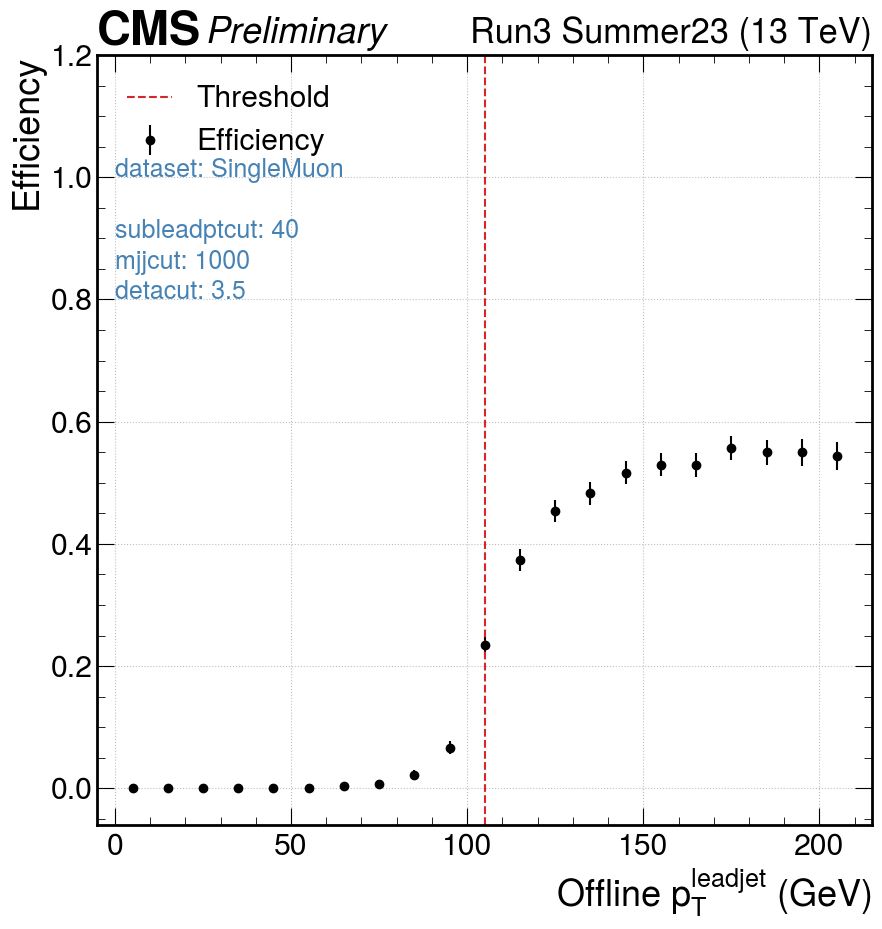

In [28]:
### PLOTTING ###

pltPath = "/eos/user/j/jkil/www/VBFSUEP/efficiency/"
plt.style.use(hep.style.CMS)
plt.figure()

plt.errorbar(bincenter,effs, yerr=[errmin,errmax], marker='o', color="black", label="Efficiency", linestyle='')
plt.xlabel(vardict["xlabel"])
plt.ylabel("Efficiency")
plt.ylim(-0.06,1.2)
hep.cms.text("Preliminary")
hep.cms.lumitext(r"Run3 Summer23 (13 TeV)")
plt.axvline(x=vardict["threshold"], color='tab:red', label="Threshold", linestyle="--")

plt.text(0,1.0,"dataset: {}".format(datasetname), size='x-small', color='steelblue')
if not LeadJetPtAnalysis: plt.text(0,0.95,"leadptcut: {}".format(triggerdict["leadjetpt"]), size='x-small', color='steelblue')
if not SubleadJetPtAnalysis: plt.text(0,0.9,"subleadptcut: {}".format(triggerdict["subleadjetpt"]), size='x-small', color='steelblue')
if not MjjAnalysis: plt.text(0,0.85,"mjjcut: {}".format(triggerdict["mjj"]), size='x-small', color='steelblue')
if not DetaAnalysis: plt.text(0,0.8,"detacut: {}".format(triggerdict["deta"]), size='x-small', color='steelblue')

plt.legend(loc=2)
plt.grid()
if TighterCuts: plt.savefig("{0}{1}{2}TightEff.png".format(pltPath,datasetname,vardict["plotname"]))
else:           plt.savefig("{0}{1}{2}Eff.png".format(pltPath,datasetname,vardict["plotname"]))

In [ ]:
# Why efficiency over 1 with tighter cuts?